# Data Cleaning/Wrangling: Cary5000 data

Often, the data we collect in laboratories or gather from other sources is not formatted or organized in a way that facilitates our analysis of the data. 

One such example is the data collected on the ubiquitous Cary5000 (and Cary60) spectrometer. There are several issues with the structure of raw Cary data which hinder data analysis. These issues are discussed just below. Feel free to read about them or skip ahead.

### Issues with raw Cary data:

**First,** Cary data include 2 rows of headers (blue text, Figure A). The first header (row 1) includes the name (scan_name) for each measurement. This is important information for the analysis of this data; however, each scan_name is located over the independent variable (Wavelength) rather than the dependent variable of interest (Absorbance). The second header (second row) is identical for each measurement and provides no additional information of value.

**Second,** the independent variable of this 2D data set (Wavelength) is repeated for each measurement (green text, Figure A). This makes the data unnecessarily clunky and can cause more serious issues when many, many measurements are collected.

**Third,** at the bottom of the csv file, additional information is given for each measurement (eg measurement time stamp, red text, Figure B). This information is often necessary or helpful in the data analysis process, but the only way to access it in the current data structure is to scroll through each measurement and copy the desired data (very tedious!).

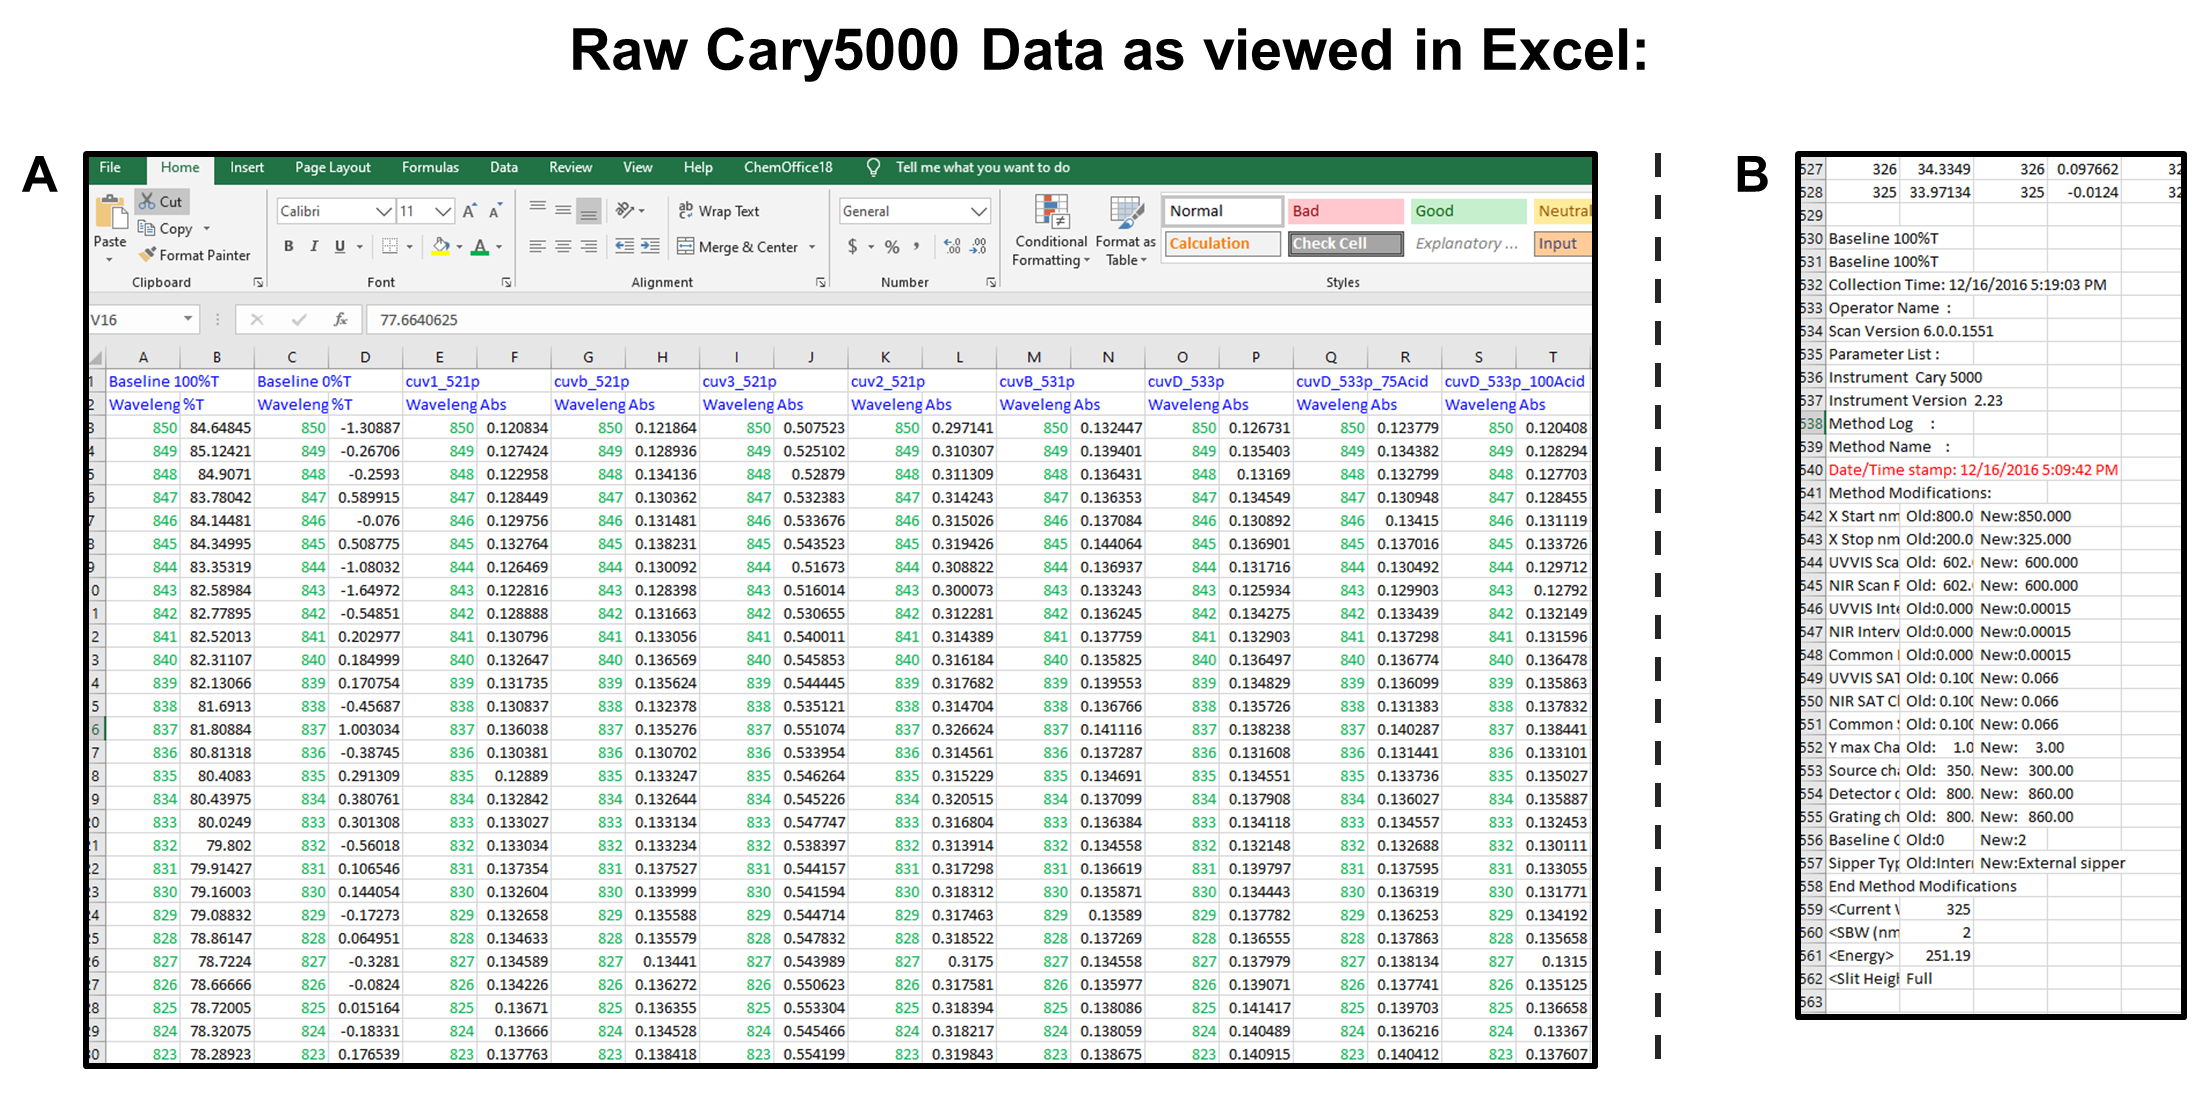

In [1]:
from IPython.display import Image
Image('Raw_Cary_Data_Excel.png')

#### The Python program outlined in this Notebook was created to facilitate the following:
#### 1. Automation of Cary data cleaning and visualization, specifically of desired Absorbance vs. Wavelength plots.
#### 2. Extraction of time data for each collected data point (buried in the bottom of the csv file).

# Part 1: Data Cleaning & Plotting

Result: The 2D data structure of the cleaned CSV file generated in Part 1 is amendable for work in Tableau, Excel, and many other data visualization programs. However, the data can also be visualized with matplotlib, as shown below.

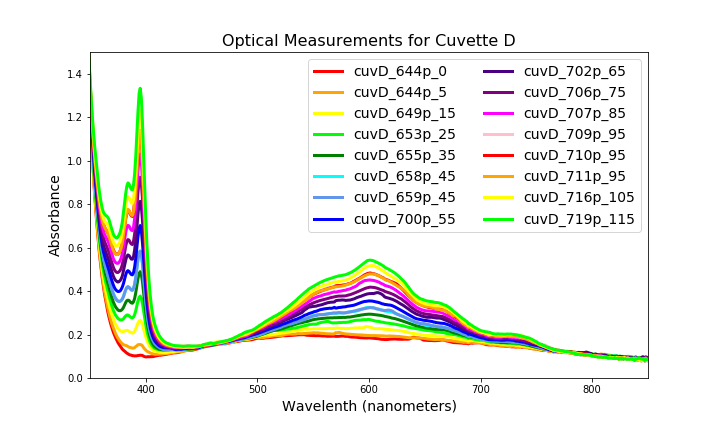

In [2]:
Image('Figure.png')

### 1. Import necessary packages and libraries.

In [3]:
import numpy as np
import pandas as pd 

### 2. Open Cary data and read in each line of data.

In [4]:
cary_file_path_name = "P1_5.csv"

with open(cary_file_path_name, 'r') as f:
    raw_cary_data = f.readlines() 

### 3. Create a list of scan names (which will double as a list of column names for our dataframe)
The first line of the csv file is a long string containing the header data (or scan name) for each scan. In the string, the scan names are separated by commas as follows:

'scan_name_1,,scan_name_2,,scan_name_3,,....scan_name_n'

The string is split on all commas and stored in the list "Scan_Names" with step size 2 to skip over would be empty strings ('') in the list.

Duplicate scan names are identified and altered, a necessary step since scan names will eventually be used as the column names of a dataframe.

In [5]:
Scan_Names = raw_cary_data[0].split(",")[::2]

#Identify duplicate scan names:
Duplicate_names = {}
for x in set(Scan_Names):
    if Scan_Names.count(x) == 1:
        continue
    else:         # If Scan_Names.count(x) > 1
        Duplicate_names[x] = (Scan_Names.count(x))
        print("{0}\n{1}".format(x, Scan_Names.count(x)))

# Rename duplicate scan names to make them unique.
for key in Duplicate_names.keys():
    indexes = []
    for i in range(len(Scan_Names)):
        if key == Scan_Names[i]:
            indexes.append(i)
    
    counter = 1
    for i2 in indexes[1:]:
        counter += 1
        Scan_Names[i2] = Scan_Names[i2]+"_"+str(counter)

Cuv2_839p_95_10
2
Baseline 0%T
3
Baseline 100%T
3


### 4. Extract wavelength (measured in nanometers, nm) and absorbance values for each scan:

First, The end of the spectral (scan) data in "raw_carry_data" is determined using the "Find_Scan_Data_End" function.

Next, a for loop is used to store wavelength (nm) and a list of absorbance values (one for each scan) respectively as keys and values in a dictionary.  

The dataframe is created from the dictionary, using wavelength as the index and Scan_Names for the column names.  

In [25]:
# Determine the end of the spectral (scan) data:

def Find_Scan_Data_End(lines_of_csv_file):
    fisrt_blank_line = []
    
    while len(fisrt_blank_line) < 1:
        for i in range(len(lines_of_csv_file)):
            if lines_of_csv_file[i][0] == ',' or lines_of_csv_file[i][0] == '\n':    # when TRUE, the end of the spectral data has been reached
                fisrt_blank_line.append(i)
                
    return fisrt_blank_line[0]


scan_data_end = Find_Scan_Data_End(raw_cary_data)
print(scan_data_end)

528


In [12]:
Wavelength_Absorbance = {}

for line in raw_cary_data[2:scan_data_end]:
    split_line = line.split(",")                          # Split string on commas.
    nm = float(split_line[0])                             # Extract wavelength (nm) value once.
    absorbance = [float(A) for A in split_line[1::2]]     # Extract absorbance value at nm for each scan
    Wavelength_Absorbance[nm] = absorbance    

In [13]:
scans_df = pd.DataFrame.from_dict(Wavelength_Absorbance, orient = 'index', columns = Scan_Names)
scans_df.head(2)

,Baseline 100%T,Baseline 0%T,cuv1_521p,cuvb_521p,cuv3_521p,cuv2_521p,cuvB_531p,cuvD_533p,cuvD_533p_75Acid,cuvD_533p_100Acid,...,Cuv2_839p_95_10_2,Cuv2_840p_95_10,Cuv1_842p_fin,Cuv3_843p_fin_nostir,Cuv3_843p_fin_stir,Cuv2_845p_fin,CuvB_846p,CuvD_846p_fin,Cuv2_848p_fin,blank_848p
850.0,84.648445,-1.308874,0.120834,0.121864,0.507523,0.297141,0.132447,0.126731,0.123779,0.120408,...,0.339147,0.333447,0.232744,1.172894,1.149855,0.325538,0.119581,0.138002,0.318888,0.032659
849.0,85.124214,-0.267062,0.127424,0.128936,0.525102,0.310307,0.139401,0.135403,0.134382,0.128294,...,0.332541,0.326036,0.233996,1.147926,1.135474,0.327201,0.120354,0.140507,0.320488,0.034837


### 5. Write a "cleaned" CSV file containing Wavelength vs Absorbance data for each scan.
The simple 2D data structure of the cleaned CSV file is amendable for work in Tableau, Excel, and many other data visualization programs.

In [14]:
scans_df.to_csv("scans.csv", index_label="Wavelength_nm")

### 6. Alternatively, the data can be plotted using MatPlotLib:

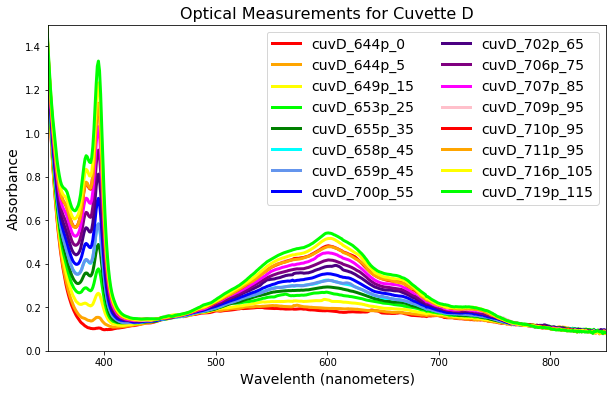

In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


# Create Plot:
fig, ax = plt.subplots(figsize=(10,6))


# Plot X (wavelength) and y (all columns for Cuvette D, cuvD) in the scans_df::
X = scans_df.index.tolist()
CuvD_Cols = [col for col in scans_df.columns if 'cuvD' in col]
colors  = ["red", "orange", "yellow", "lime", "green", "cyan", "cornflowerblue", "blue", "indigo", "purple", "fuchsia", "pink", "red", "orange", "yellow", "lime", "green", "cyan", "cornflowerblue", "blue", "indigo", "purple", "fuchsia", "pink", "red", "orange", "yellow", "lime", "green", "cyan"]

counter = -1
for col in CuvD_Cols[3:-5]:
    y = scans_df[col].tolist()
    counter += 1
    ax.plot(X, y, color = colors[counter], linewidth=3, label = col)

    
# Set Axis, Title, Lgend Details:
ax.set_title("Optical Measurements for Cuvette D", fontsize = 16)
ax.set_ylabel('Absorbance', fontsize = 14)
ax.set_xlabel('Wavelenth (nanometers)', fontsize = 14)
ax.set_ylim(bottom = 0, top = 1.5)
ax.set_xlim(left = 350, right = 850)
ax.legend(ncol = 2, loc = 1, fontsize = 14)

plt.savefig("figure.png")

# Part 2: Extraction of Time Data

Result: In part 2, another CSV file with both absorbance and time data is created. This makes analysis of absorbance as a function of time fast and simple (plotted below). 

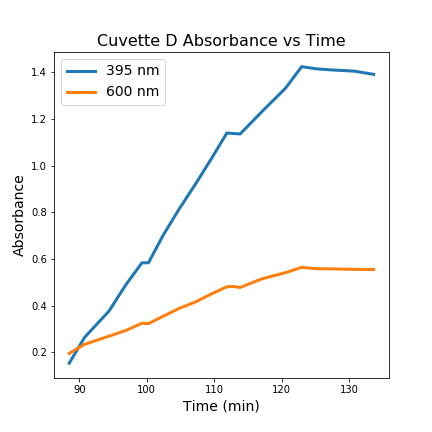

In [23]:
Image('Figure2.png')

### 1. Import additional necessary packages and libraries.

In [24]:
import datetime
import re
import csv

### 2. Using the raw_cary_data extracted in Part 1 section 2, datetimes for each collected scan are extracted from the bottom half of the raw_cary_data:
Extract collection time and date as strings from raw_data.

Convert the strings to datetime objects and store in list "collection_datetime".

Determine the difference in minutes between each datetime object, store in list "delta_time".

In [17]:
regex = re.compile("Collection Time: (.*M),*")
collection_datetime = []

for row in raw_cary_data[scan_data_end:]:
    m = regex.match(row)
    if m:
        time = datetime.datetime.strptime(m.group(1), '%m/%d/%Y %I:%M:%S %p')
        collection_datetime.append(time)
    else:
        continue

delta_time = [(x-collection_datetime[0]).total_seconds()/60 for x in collection_datetime]

### 3. Add the time data as a multilevel index (along with Scan_Name) to our new dataframe (absorbance_time_df).

In [26]:
absorbance_time_df = scans_df.transpose()

ScanNames_Time = list(zip(Scan_Names, delta_time))
absorbance_time_df.index = pd.MultiIndex.from_tuples(ScanNames_Time)
absorbance_time_df.head(2)

,,850.0,849.0,848.0,847.0,846.0,845.0,844.0,843.0,842.0,841.0,...,334.0,333.0,332.0,331.0,330.0,329.0,328.0,327.0,326.0,325.0
Baseline 100%T,0.000000,84.648445,85.124214,84.907097,83.780418,84.144814,84.349945,83.353188,82.589844,82.778954,82.520126,...,36.719341,36.357620,36.153179,35.845013,35.523762,35.259632,34.987537,34.729950,34.334900,33.971340
Baseline 0%T,0.883333,-1.308874,-0.267062,-0.259296,0.589915,-0.076000,0.508775,-1.080317,-1.649715,-0.548507,0.202977,...,-0.041567,-0.023885,-0.006301,-0.001405,0.031415,0.058478,0.004960,-0.009217,0.097662,-0.012401


### 4. Write a "cleaned" CSV file containing Time vs Absorbance data for each scan.
The simple 2D data structure of the cleaned CSV file is amendable for work in Tableau, Excel, and many other data visualization programs.

In [ ]:
absorbance_time_df.to_csv("absorbance_time_df.csv",index_label=("Scan_Name", "Time_min"))

### 5. Plotting the data directly with matplot lib is also possible. 
Indexing the data to select only certain scans was accomplished using .loc as shown below.

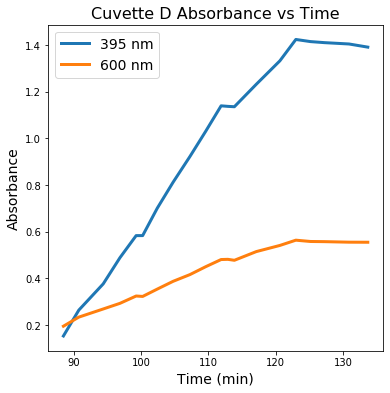

In [27]:
# Create Plot:
fig, ax = plt.subplots(figsize=(6,6))

# Creat X and y by indexing only rows for cuvette D:
CuvD_Index = [i for i in absorbance_time_df.index.get_level_values(0).tolist() if "cuvD" in i]

X_time = absorbance_time_df.loc[CuvD_Index].index.get_level_values(1).tolist()
y_absorbance_600nm = absorbance_time_df.loc[CuvD_Index][600.0].tolist()
y_absorbance_395nm = absorbance_time_df.loc[CuvD_Index][395.0].tolist()


# Plot X (wavelength) and y (all columns for Cuvette D, cuvD) in the scans_df::
ax.plot(X_time[4:], y_absorbance_395nm[4:], linewidth=3, label = "395 nm")
ax.plot(X_time[4:], y_absorbance_600nm[4:], linewidth=3, label = "600 nm")

# Set Axis, Title, Lgend Details:
ax.set_title("Cuvette D Absorbance vs Time", fontsize = 16)
ax.set_ylabel('Absorbance', fontsize = 14)
ax.set_xlabel('Time (min)', fontsize = 14)
ax.legend(ncol = 1, loc =2, fontsize = 14)

plt.savefig("figure2.png")